# Project: Bank Customer Churn Clustering
# Type: Customer Segmentation
# Techniques: DBSCAN, PCA, Silhouette Score, Accuracy
# Dataset: Bank Customer Churn Prediction.csv
# By - Priyanshu



## Mount the drive

In [122]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Check the files inside the drive

In [123]:
!ls /content/gdrive/MyDrive/

'Bank Customer Churn Prediction.csv'  'Colab Notebooks'


## Import the file

In [124]:
file_path = "/content/gdrive/MyDrive/Bank Customer Churn Prediction.csv"

## Import Libraries

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, confusion_matrix

## Load dataset and print the shape of dataset

In [126]:
df = pd.read_csv(file_path)

print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (10000, 12)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Dataset Information



In [127]:
print("\nDataset Information: ")
print(df.info())



Dataset Information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None


## Dataset Description


In [128]:
print("\nDescription of the Dataset:")
print(df.describe())


Description of the Dataset:
        customer_id  credit_score           age        tenure        balance  \
count  1.000000e+04  10000.000000  10000.000000  10000.000000   10000.000000   
mean   1.569094e+07    650.528800     38.921800      5.012800   76485.889288   
std    7.193619e+04     96.653299     10.487806      2.892174   62397.405202   
min    1.556570e+07    350.000000     18.000000      0.000000       0.000000   
25%    1.562853e+07    584.000000     32.000000      3.000000       0.000000   
50%    1.569074e+07    652.000000     37.000000      5.000000   97198.540000   
75%    1.575323e+07    718.000000     44.000000      7.000000  127644.240000   
max    1.581569e+07    850.000000     92.000000     10.000000  250898.090000   

       products_number  credit_card  active_member  estimated_salary  \
count     10000.000000  10000.00000   10000.000000      10000.000000   
mean          1.530200      0.70550       0.515100     100090.239881   
std           0.581654      0.4558

## Drop Identifier

In [129]:
# Drop customer_id (identifier)
df = df.drop(columns=["customer_id"], errors="ignore")
print("\nAfter dropping 'customer_id':")
# Show first 5 rows after dropping
df.head()


After dropping 'customer_id':


,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Identify categorical columns and convert into int

In [130]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=["object"]).columns
print("Categorical columns:", categorical_cols)

# One-Hot Encode
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

# Convert boolean columns to int
bool_cols = df_encoded.select_dtypes('bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
display(df_encoded.head())

Categorical columns: Index(['country', 'gender'], dtype='object')


,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


## Separate Features and Target + Scale Features

In [131]:
target_col = "churn"

# Features (X) and Target (y)
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Show first 5 rows before and after scaling
print("🔹 Features Before Scaling:")
display(X.head())

print("\n🔹 Features After Scaling:")
display(pd.DataFrame(X_scaled, columns=X.columns).head())


🔹 Features Before Scaling:


,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0



🔹 Features After Scaling:


,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886,0.997204,-0.578736,-0.573809,1.095988,-1.095988
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534,-1.002804,-0.578736,1.742740,1.095988,-1.095988
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.646092,-1.030670,0.240687,0.997204,-0.578736,-0.573809,1.095988,-1.095988
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-1.547768,-1.030670,-0.108918,0.997204,-0.578736,-0.573809,1.095988,-1.095988
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,0.646092,0.970243,-0.365276,-1.002804,-0.578736,1.742740,1.095988,-1.095988


## PCA (retain 90% variance)

In [132]:
pca = PCA(n_components=0.9, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Number of PCA components selected:", X_pca.shape[1])
# Create a DataFrame for visualization
pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])


print("\nFirst 5 rows after PCA:")
display(pca_df.head())

Number of PCA components selected: 10

First 5 rows after PCA:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1.387928,-1.560629,-0.523848,-1.218376,0.155052,0.380960,-0.367465,-0.298039,1.094283,0.338976
1,1.503348,0.497692,1.766645,-2.125389,-0.465381,-1.410801,-0.495027,-0.502704,0.032214,0.554024
2,1.546108,-0.946819,-0.668985,1.801669,0.221687,0.689731,-1.565935,0.314986,-0.458695,-0.340045
3,1.492500,-1.859357,-0.188735,0.110514,0.357308,-1.725317,0.242770,-1.239214,-0.423208,-1.079715
4,1.511359,0.844971,1.570735,-1.925526,-0.095822,0.270565,2.036125,0.000054,1.260365,-0.059929


## DBSCAN Clustering

In [133]:
dbscan = DBSCAN(eps=1.8, min_samples=5)
clusters = dbscan.fit_predict(X_pca)

df_encoded["Cluster"] = clusters  # ✅ Added in df_encoded

print("Clusters found:", np.unique(clusters))
print("Cluster distribution:\n", df_encoded["Cluster"].value_counts())


# Sample rows with cluster assignment
display(df_encoded.head())


Clusters found: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23]
Cluster distribution:
 Cluster
 6     1010
 18     946
 0      803
 2      766
 20     512
 13     486
 17     455
 10     454
 5      432
 7      408
 4      388
 14     377
 12     372
 8      370
 22     340
 3      327
 16     233
 11     200
 9      191
 19     166
 15     165
 21     165
 1      161
 23     146
-1      127
Name: count, dtype: int64


,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain,gender_Female,gender_Male,Cluster
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0,2
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0,3
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0,4


## Silhouette Score

Silhouette Score: 0.1716
Accuracy (Clusters vs Churn): 0.7963

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      7963
           1       0.00      0.00      0.00      2037

    accuracy                           0.80     10000
   macro avg       0.40      0.50      0.44     10000
weighted avg       0.63      0.80      0.71     10000



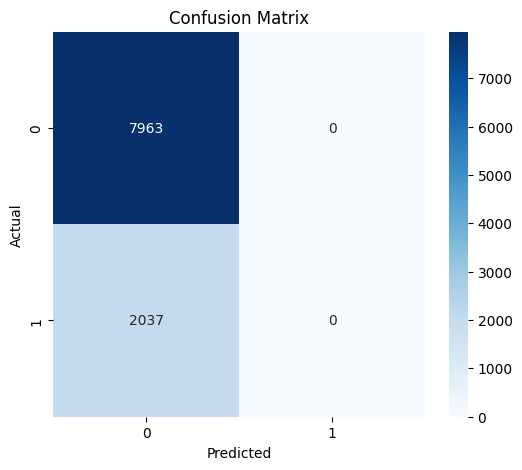

In [134]:
mask = clusters != -1
if len(np.unique(clusters[mask])) > 1:
    score = silhouette_score(X_pca[mask], clusters[mask])
    print("Silhouette Score:", round(score, 4))
else:
    print("Silhouette Score cannot be computed (only 1 cluster)")

# --- Step 10: Map Clusters to Majority Churn ---
cluster_to_label = {c: df_encoded[df_encoded["Cluster"]==c]["churn"].mode()[0]
                    for c in set(clusters) if c != -1}
majority_class = y.mode()[0]
y_pred = [majority_class if c==-1 else cluster_to_label[c] for c in clusters]

print("Accuracy (Clusters vs Churn):", round(accuracy_score(y, y_pred), 4))
print("\nClassification Report:\n", classification_report(y, y_pred, zero_division=0))

# --- Step 11: Confusion Matrix ---
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Cluster Analysis & Visualization

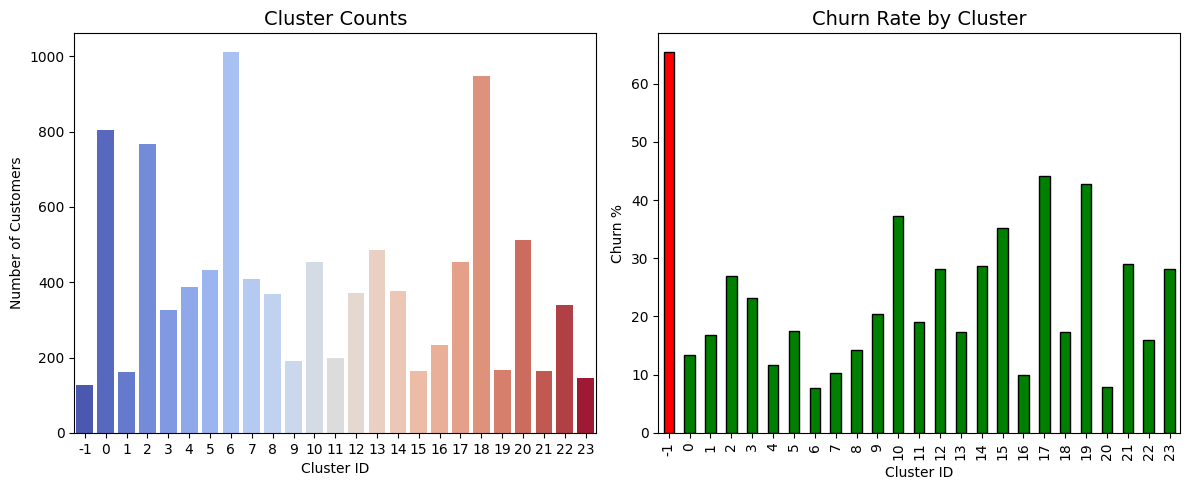

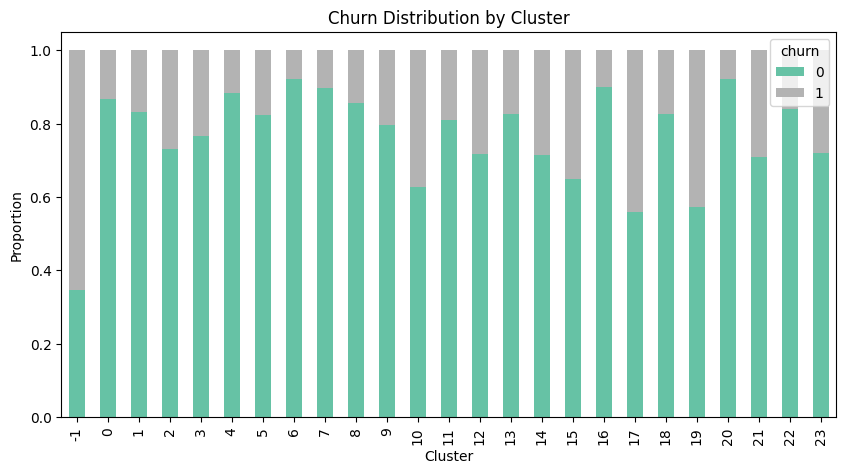

In [135]:
if "Cluster" in df_encoded.columns:
    plt.figure(figsize=(12,5))

    # Plot 1: Cluster Counts
    plt.subplot(1,2,1)
    sns.countplot(x="Cluster", hue="Cluster", data=df_encoded, palette="coolwarm", legend=False)
    plt.title("Cluster Counts", fontsize=14)
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Customers")

    # Plot 2: Churn Rate by Cluster
    churn_rate = df_encoded.groupby("Cluster")[target_col].mean() * 100
    colors = ["red" if rate > 50 else "green" for rate in churn_rate]

    plt.subplot(1,2,2)
    churn_rate.plot(kind="bar", color=colors, edgecolor="black")
    plt.title("Churn Rate by Cluster", fontsize=14)
    plt.xlabel("Cluster ID")
    plt.ylabel("Churn %")

    plt.tight_layout()
    plt.show()

    # Churn distribution by cluster
    churn_dist = df_encoded.groupby("Cluster")[target_col].value_counts(normalize=True).unstack().fillna(0)
    churn_dist.plot(kind='bar', stacked=True, figsize=(10,5), colormap='Set2')
    plt.title("Churn Distribution by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Proportion")
    plt.show()

# Conclusion

**Data Preparation & Transformation**

We cleaned the dataset by removing identifiers and applying one-hot encoding for categorical variables.

Features were standardized and reduced with PCA, retaining ~90% of the variance while reducing dimensionality.

**Clustering with DBSCAN**

DBSCAN was chosen because it can discover clusters of varying shapes and also detect outliers/noise (-1 cluster).

The algorithm formed 23 meaningful clusters plus a small noise group.

**Cluster Quality**

The silhouette score (~0.17) indicates that clusters are present, but the separation between them is not very strong.

This suggests customer behavior overlaps significantly, which is common in real-world financial datasets.

**Churn Insights**

Overall accuracy of ~79.6% was achieved when mapping clusters to majority churn labels.

However, the classification report shows the model captures non-churners (class 0) very well, but struggles to identify churners (class 1).

This is because churners form a minority (20.3%) in the dataset, leading to class imbalance.

**Business Value**

Even with modest cluster separation, DBSCAN helps in segmenting customers into behavioral groups.

Certain clusters show higher churn rates, which can be targeted for retention campaigns.

This segmentation enables banks to design personalized offers, better credit policies, and targeted customer engagement strategies.

# Thank you